In [2]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

##  Table of Contents
- [1. Prepare Data & Select Target and Features](#1-start)
- [2. NN Models](#2-nn-models)
  - [2.1 Model Creation](#21-model-creation)
  - [2.2 Train and Test the NN Models](#22-train-and-test-the-nn-models)
  - [2.3 Save Model Results and Error Metrics](#23-save-model-results-and-error-metrics)
- [2. XGBRegressor Model](#2-xgbregressor-model)
- [3. Model Performance Summary](#3-model-performance-summary)
- [4. XGBoost Performance Visualization: Actual vs Predicted, Residuals, and Distribution](#4-results-discussion-and-conclusion)
- [5. Results Discussion and Conclusion](#5-results-discussion-and-conclusion)


## 1. Prepare Data & Select Target and Features

In [3]:
df = pd.read_csv("data/df_main.csv")
df.head()

,Date,O3,CO,SO2,NO2,O3 AQI,CO AQI,SO2 AQI,NO2 AQI,PM2.5,PM10,AWND,PRCP,TAVG,year,month,season
0,2013-01-06,0.023118,0.826667,0.201897,20.346291,35.2,16.0,2.6,35.8,14.846154,7.0,5.816,0.060357,5.211640,2013,1,Winter
1,2013-01-07,0.014800,0.773333,0.405771,25.954058,28.8,13.6,0.8,42.4,8.773684,12.0,6.845,0.028704,8.121693,2013,1,Winter
2,2013-01-10,0.035435,0.479318,0.116403,10.987455,35.0,6.6,0.2,24.8,6.047619,16.0,12.772,0.038704,4.417989,2013,1,Winter
3,2013-01-11,0.031777,0.488333,0.146759,10.901153,33.6,7.0,0.6,29.2,3.258333,8.0,9.955,0.006792,1.931217,2013,1,Winter
4,2013-01-12,0.016682,0.608333,0.254901,21.156410,28.8,11.8,0.4,37.2,9.776923,8.0,4.542,0.000192,2.142857,2013,1,Winter


In [4]:
df.describe()

,O3,CO,SO2,NO2,O3 AQI,CO AQI,SO2 AQI,NO2 AQI,PM2.5,PM10,AWND,PRCP,TAVG,year,month
count,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000
mean,0.027724,0.387015,0.404999,16.572092,39.428778,6.317779,1.031185,28.280393,11.716302,23.264473,6.777175,0.031544,17.267196,2017.561548,6.485679
std,0.008779,0.190818,0.257904,8.343270,14.239448,3.529850,1.231693,11.679719,4.334258,11.520286,1.874114,0.150335,6.033154,2.818932,3.366826
min,0.001971,0.065278,0.000000,0.269565,4.250000,1.000000,0.000000,1.000000,2.410526,0.000000,2.036667,0.000000,1.481481,2013.000000,1.000000
25%,0.021824,0.235417,0.205052,9.858004,31.500000,3.500000,0.000000,19.000000,8.787619,15.000000,5.413250,0.000000,12.627910,2015.000000,4.000000
50%,0.028404,0.335882,0.365530,14.884375,37.750000,5.500000,0.750000,27.000000,11.116409,23.000000,6.732000,0.000000,17.294686,2018.000000,7.000000
75%,0.034230,0.499801,0.565128,22.307986,43.800000,8.500000,1.500000,37.000000,14.123214,30.000000,7.918000,0.000600,22.173913,2020.000000,9.000000
max,0.053118,1.016667,1.257510,41.273732,161.000000,19.333333,12.250000,75.666667,28.385000,71.000000,12.773000,2.284364,32.433862,2022.000000,12.000000


In [5]:
from utils.func_tools import create_dataloaders

# Select features based on correlation heatmap
features = ["CO", "PM2.5", "AWND", "PM10", "O3", "SO2", "TAVG", "PRCP"]

target = "NO2"

# Split dataset
X = df[features]
y = df[target]
print(f"Shape of X = {X.shape}")
print(f"Shape of y = {y.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11
)

print(f"Shape of X_train = {X_train.shape}")
print(f"Shape of X_test = {X_test.shape}")

# create dataloader
train_dataloader, test_dataloader = create_dataloaders(
    X_train, y_train, X_test, y_test, batch_size=32
)

Shape of X = (3282, 8)
Shape of y = (3282,)
Shape of X_train = (2625, 8)
Shape of X_test = (657, 8)


In [271]:
# Iterate over the first batch in train_loader and inspect
for __, (features, targets) in enumerate(train_dataloader):
    print("Inputs shape:", features.shape)  # Should be [batch_size, num_features]
    print("Targets shape:", targets.shape)  # Should be [batch_size]
    print("Features example:\n", features[:2])
    print("Targets example:\n", targets[:2])
    break

Inputs shape: torch.Size([32, 8])
Targets shape: torch.Size([32])
Features example:
 tensor([[-0.0631, -0.1075, -0.7149, -1.6892, -1.7323, -1.3429,  0.4277,  1.0433],
        [-0.3591,  0.6053, -0.8340,  1.0426,  1.0517, -1.4443,  0.7118, -0.2070]])
Targets example:
 tensor([21.4444,  7.9542])


## 2. NN Models

### 2.1 Model Creation

In [272]:
device = "cuda" if torch.cuda.is_available() else "cpu"


# NN Model
class MLP(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
        )

    def forward(self, x: torch.Tensor):
        return self.model(x)

### 2.2 Train and Test the NN Models

In [ ]:
torch.manual_seed(42)
# import functions from func_tools
from utils.func_tools import (
    train_step,
    test_step,
    print_train_time,
    mae_fn,
    rmse_fn,
    r2_fn,
)

input_dim = X_train.shape[1]
model = MLP(input_shape=input_dim, hidden_units=128, output_shape=1)

model_name = model.__class__.__name__
print(f"\nTraining model: {model_name}")
print("=====================================================")

# L1:
l1_lambda = 1e-4
# L2:
l2_lambda = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=0.008, weight_decay=l2_lambda)
loss_fn = nn.MSELoss()

errors_fns = [mae_fn, rmse_fn, r2_fn]


# Measure time
from timeit import default_timer as timer

time0 = timer()

# Train and test model
epochs = 6
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(
        data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        metric_fn=mae_fn,
        device=device,
        l1_lambda=l1_lambda,
    )

    # Test the model no optimization
    final_preds, final_labels = test_step(
        data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        metric_fn=mae_fn,
        device=device,
    )

time1 = timer()
total_train_time_model = print_train_time(start=time0, end=time1, device=device)
print("=====================================================")


Training model: MLP


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0
---------


 17%|█▋        | 1/6 [00:00<00:02,  2.05it/s]

Train loss: 44.33419 | Train Error: 4.79436
Test loss: 16.16029 | Test MAE: 3.15795
Epoch: 1
---------


 33%|███▎      | 2/6 [00:00<00:01,  2.23it/s]

Train loss: 17.46528 | Train Error: 3.15699
Test loss: 13.58951 | Test MAE: 2.74855
Epoch: 2
---------


 50%|█████     | 3/6 [00:01<00:01,  2.28it/s]

Train loss: 13.52710 | Train Error: 2.78022
Test loss: 11.84388 | Test MAE: 2.69935
Epoch: 3
---------


 67%|██████▋   | 4/6 [00:01<00:00,  2.34it/s]

Train loss: 13.47893 | Train Error: 2.75185
Test loss: 9.61046 | Test MAE: 2.37920
Epoch: 4
---------


 83%|████████▎ | 5/6 [00:02<00:00,  2.37it/s]

Train loss: 12.91607 | Train Error: 2.72633
Test loss: 9.47037 | Test MAE: 2.35880
Epoch: 5
---------


100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

Train loss: 11.76194 | Train Error: 2.58212
Test loss: 9.01034 | Test MAE: 2.31175

Train time on cpu: 2.713 seconds


### 2.3 Save Model Results and Error Metrics

In [274]:
errors_dict = {"model_name": "NN with L1+L2"}

for metric_fn in errors_fns:
    error_name = metric_fn.__name__.replace("_fn", "").upper()
    error_value = metric_fn(final_labels, final_preds)
    errors_dict[error_name] = error_value
    print(f"{error_name}: {error_value:.5f}")

errors_dict

MAE: 2.31175
RMSE: 3.00172
R2: 0.87655


{'model_name': 'NN with L1+L2',
 'MAE': 2.311750650405884,
 'RMSE': 3.001722953673905,
 'R2': 0.8765546679496765}

In [ ]:
from utils.func_tools import handle_metrics_RM

handle_metrics_RM(errors_dict, mode="save")

Saved metrics.


In [277]:
handle_metrics_RM(errors_dict, mode="display")

Model Name                  MAE   R² Score       RMSE
-------------------------------------------------------
NN                       2.3180     0.8760     3.0079
NN with L2 penalty       2.3346     0.8740     3.0321
NN with L1 penalty       2.3354     0.8735     3.0381
NN with L1+L2            2.3118     0.8766     3.0017
XGBRegressor             2.2481     0.8851     2.8855


## 2. XGBRegressor Model

In [278]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

model.fit(X_train, y_train)
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"Model: XGBRegressor")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

Model: XGBRegressor
MAE: 2.2481
RMSE: 2.8855
R^2: 0.8851


In [279]:
errors_dict = {"model_name": "XGBRegressor"}
errors_dict["MAE"] = mae
errors_dict["RMSE"] = rmse
errors_dict["R2"] = r2

In [ ]:
handle_metrics_RM(errors_dict, mode="save")
handle_metrics_RM(errors_dict, mode="display")

Model Name                  MAE   R² Score       RMSE
-------------------------------------------------------
NN                       2.3180     0.8760     3.0079
NN with L2 penalty       2.3346     0.8740     3.0321
NN with L1 penalty       2.3354     0.8735     3.0381
NN with L1+L2            2.3118     0.8766     3.0017
XGBRegressor             2.2481     0.8851     2.8855


## 3. Model Performance Summary


| Model Name           | MAE    | R² Score | RMSE   |
|----------------------|--------|----------|--------|
| Neural Network (NN)                 | 2.3180 | 0.8760   | 3.0079 |
| NN with L2 Penalty (Ridge)          | 2.3346 | 0.8740   | 3.0321 |
| NN with L1 Penalty (Lasso)          | 2.3354 | 0.8735   | 3.0381 |
| NN with L1 + L2 (ElasticNet)        | 2.3118 | 0.8766   | 3.0017 |
| **XGBoost Regressor**               | **2.2481** | **0.8851**   | **2.8855** |

### Key Observations:
- The **XGBoost Regressor** outperformed all neural network variants in terms of **lowest MAE, highest R², and lowest RMSE**.
- Among the neural network models, the **L1+L2 (ElasticNet)** regularization provided the best performance.
- Adding L1 or L2 penalties slightly reduced performance compared to the base NN, suggesting limited overfitting in the unregularized model.


## 4. XGBoost Performance Visualization: Actual vs Predicted, Residuals, and Distribution

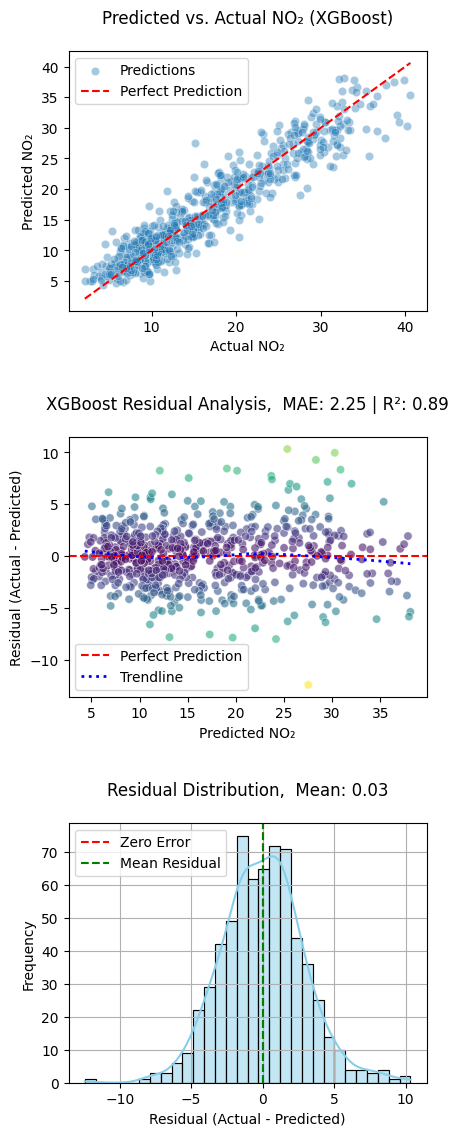

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train model
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

# Calculate residuals
residuals = y_test - preds

# Create figure with 3 subplots vertically
plt.figure(figsize=(5, 12))

# --- Plot 1: Actual vs Predicted ---
plt.subplot(3, 1, 1)
sns.scatterplot(x=y_test, y=preds, alpha=0.4, label="Predictions")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--",
    label="Perfect Prediction",
)
plt.xlabel("Actual NO₂")
plt.ylabel("Predicted NO₂")
plt.title("Predicted vs. Actual NO₂ (XGBoost)", pad=20)
plt.legend()

# --- Plot 2: Residual Plot ---
plt.subplot(3, 1, 2)
sns.scatterplot(
    x=preds,
    y=residuals,
    alpha=0.6,
    hue=np.abs(residuals),
    palette="viridis",
    edgecolor="w",
    linewidth=0.5,
    legend=False,
)

# Zero line and trendline
plt.axhline(0, color="red", linestyle="--", linewidth=1.5, label="Perfect Prediction")
sns.regplot(
    x=preds,
    y=residuals,
    scatter=False,
    color="blue",
    lowess=True,
    line_kws={"linestyle": ":", "linewidth": 2},
    label="Trendline",
)

plt.xlabel("Predicted NO₂")
plt.ylabel("Residual (Actual - Predicted)")
plt.title(
    "XGBoost Residual Analysis,  MAE: {:.2f} | R²: {:.2f}".format(mae, r2), pad=20
)
plt.legend()

# --- Plot 3: Residual Distribution ---
plt.subplot(3, 1, 3)
sns.histplot(residuals, kde=True, bins=30, color="skyblue")
plt.axvline(0, color="red", linestyle="--", label="Zero Error")
plt.axvline(np.mean(residuals), color="green", linestyle="--", label="Mean Residual")
plt.title("Residual Distribution,  Mean: {:.2f}".format(np.mean(residuals)), pad=20)
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

plt.tight_layout(pad=3.0)
plt.show()

## 5. Results Discussion and Conclusion

The XGBoost model shows reasonable predictive performance for NO₂ levels, with most points clustered near the ideal prediction line. Key observations:

- **Accuracy**: Best performance in mid-range concentrations (5-30 units)
- **Patterns**: 
  - Slight under-prediction at high concentrations (>30)
  - Some over-prediction at low concentrations (<5)


**Residual analysis will provide further error insights:**

<br>

---

## Understanding Our Residuals  
This plot shows the errors (actual - predicted) across different NO₂ levels. With an R² of 0.89 and average error of 2.25 units, we're doing pretty well!  

**What we see**:  
- Most predictions are within ±5 units of the true values  
- A few predictions miss by more than 10 units  

<br>

---

## Heteroscedasticity Analysis
The residual plot demonstrates **homoscedasticity** (consistent error variance across predicted values), indicating our model handles variance well structurally. The observed overprediction at lower concentrations (<10 units) is likely due to:
- Data scarcity in extreme ranges
- Fewer training samples for low-concentration patterns

**Conclusion**:  
The model shows robust error distribution (MAE=2.25, R²=0.89), with minor biases attributable to sample limitations rather than systematic variance issues. 

<br>

---

## Residual Distribution Analysis
The histogram reveals a well-behaved error distribution with:
- **Near-zero mean residual (0.03)**: Indicates minimal systematic bias  
- **Symmetric shape**: Errors are evenly distributed around zero  
- **Light tails**: Few extreme prediction errors (most within ±5 units)  

**Key Insights**:
1. The normal-like distribution confirms proper model specification
2. Mean near zero suggests no significant under/over-prediction bias
3. Tight clustering around zero aligns with our strong R² (0.89)

